<a href="https://colab.research.google.com/github/yexf308/AdvancedMachineLearning/blob/main/Manifold_learning_Isomap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This lecture is partially based on Prof. Guangliang Chen's [course slides.](https://www.sjsu.edu/faculty/guangliang.chen/Math250.html)

In [1]:
%pylab inline 
from IPython.display import Image
import numpy.linalg as LA

Populating the interactive namespace from numpy and matplotlib


$\def\m#1{\mathbf{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
# ISOMap
Briefly, ISOmap is MDS with a special metric, called **geodesic distance**,
for reducing the dimensionality of data sampled from a smooth manifold.

### Motivation
Consider applying classical MDS to the Swissroll:

- The MDS dimension needs to be higher, and sometimes much higher,
than the manifold dimension, otherwise MDS may project faraway
points along the manifold to nearby locations. 

- MDS cannot capture the curved dimensions (its principal directions
are generally not meaningful).



In [2]:
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/swiss1.png?raw=true', width=400))
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/swiss2.png?raw=true', width=400))


### Method
Instead of preserving the Euclidean
distance, we will apply MDS to preserve
the **geodesic distance**, 

- it captures the true, nonlinear
geometry corresponding to the
curved dimension. 

- it allows to see the transitioning
along the manifold (and thus
the global structure).

### What is geodesic distance?
The geodesic distance of two data
points that live in a manifold is the
shortest distance along the manifold.

On a sphere, it is just the great-circle
distance.

The exact geodesic distances are often
impossible to find (unless we
know the true manifold).

In [3]:
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/great_circle.png?raw=true', width=400))


In practical settings where we are only given a data set $\m{X}$ sampled from an unknown manifold $\c{M}$, we can approximate the true geodesic distances $d_{\c{M}}(\m{x}^{(i)},\m{x}^{(j)})$ by the shortest-path distance $d_{G}(i,j)$ on a nearest-neighbor
graph $G$ built on the data set.

In [4]:
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/swiss3.png?raw=true', width=800))

## Algorithm
- Build a neighborhood graph $G$ from the given data by connecting only "nearby points" with edges weighted by their Euclidean distances. 
$$ d_{\c{M}}(\m{x}^{(i)},\m{x}^{(j)})=\begin{cases}\|\m{x}^{(i)}-\m{x}^{(j)}\| & \text{if $\m{x}^{(i)}$, $\m{x}^{(j)}$ are "close", }\\ 0 &\text{Otherwise}
\end{cases}$$
where "closeness" is defined in one of the following ways: 
   
   - **$\epsilon$-ball approach**: For each $\m{x}^{(i)}$, another point $\m{x}^{(j)}$ is close if and only if $\|\m{x}^{(i)} -\m{x}^{(j)}\|\le \epsilon$.    $\ \epsilon$ can treated as the resolution.
   - **$k$-NN approach**: For each point $\m{x}^{(i)}$ and $\m{x}^{(j)}$ is close if it is among the the $k$-nearest neighbors of $\m{x}^{(i)}$.

- Apply Dijkstra’s algorithm with the nearest neighbor graph $G$ to find the shortest-path distances for all pairs of data points $d_{G}(i,j)$.  

In [5]:
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/neighbor.png?raw=true', width=800))

**Input:** Pairwise distances $\ell_{ij}=\|\m{x}^{(i)}- \m{x}^{(j)} \|$ of data points in the input space, embedding dimension $d$, neighborhood graph method ($\epsilon$-ball or $k$-NN)

**Output:** A $d$-dimensional representation of the data $\m{Z}\in \mb{R}^{N\times d}$

- Construct a neighborhood graph $G$ from the given distances $\ell_{ij}$ using the specified method. 

- Compute the shortest-path distances $d_G(i,j)$ between all vertices of $G$ by using Dijkstra’s algorithm.

- Apply MDS with $d_G(i,j)$ as input distances to find a $d$-dimensional representation $\m{Z}$ of the original data. 

In [6]:
def MDS(L,d,figure=False):
  D = L*L
  N = D.shape[1]
  onesN  = ones(N)
  DonesN = dot(D, onesN)
  G2 = array([onesN]).T @ array([DonesN])/N
  G  = -(D-G2-G2.T+sum(DonesN)/N**2)/2
  U,Lambda,Vh = svd(G)
  Z = dot(U[:,:d], diag(sqrt(Lambda[:d])))
  if figure:
    plt.scatter(arange(1,N+1), sqrt(Lambda))
  return Z

In [7]:
from scipy.sparse.csgraph import dijkstra
def IsoMap(L,d,eps):
  N = L.shape[1]
  adj =  zeros([N, N]) + np.inf
  bln = L < eps
  adj[bln] = L[bln]
  dist_matrix= dijkstra(csgraph=adj, directed=False)
  if isinf(sum(dist_matrix)):
    print('increase eps to make graph fully connected')
    return

  Z= MDS(dist_matrix, d, figure=True)
  return Z


In [8]:
from sklearn.datasets import make_swiss_roll
import plotly.express as px

n_samples = 1000
noise = 0.05
X, color = make_swiss_roll(n_samples, noise=noise)
fig =  px.scatter_3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], color=color, size=5*ones(1000))
fig.update_traces(marker=dict(size=2))
fig.show()

N = X.shape[0]
L = zeros([N,N])
for i in range(N):
  for j in range(N):
    L[i,j]=norm(X[i]-X[j],2)


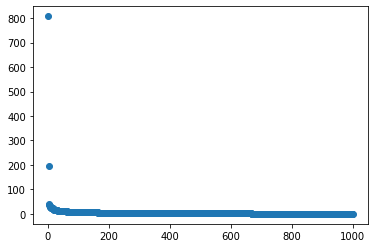

In [9]:
d=2
eps=5
Z = IsoMap(L,d,eps)

In [10]:
fig =  px.scatter(x=Z[:, 0], y=Z[:, 1], color=color)
fig.show()

In [11]:
# verify it with sklearn package
from sklearn import manifold
iso = manifold.Isomap(n_neighbors=8, n_components=2)
iso.fit(X)
manifold_2Da = iso.transform(X)

In [12]:
fig =  px.scatter(x=manifold_2Da[:, 0], y=manifold_2Da[:, 1], color=color)
fig.show()

#Handwritten digits


In [13]:
from sklearn.datasets import load_digits
digits = load_digits() 

X = digits.data
y = digits.target 

N = X.shape[0]
L = zeros([N,N])
for i in range(N):
  for j in range(N):
    L[i,j]=norm(X[i]-X[j])

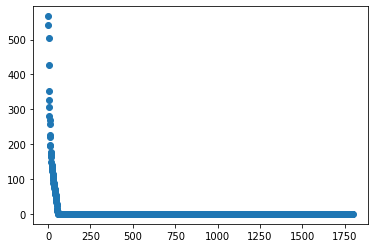

In [14]:
d=3
eps=80
Z = IsoMap(L,d,eps)

In [15]:
fig = px.scatter_3d(None, 
                    x=Z[:,0], y=Z[:,1], z=Z[:,2],
                    color=y.astype(str),
                    height=900, width=900
                   )

# Update marker size
fig.update_traces(marker=dict(size=2))
fig.show()

As you can see, Isomap has done a wonderful job in reducing dimensions from 64 to 3 while preserving non-linear relationships. This enabled us to visualize the clusters of handwritten digits in a 3-dimensional space.

If we wished, we could now easily use one of the classification models such as Decision Trees, SVM, or KNN to predict each handwritten digit label.

Isomap is one of the best tools for dimensionality reduction, enabling us to preserve non-linear relationships between data points.

### Issue of ISOmap

if the data is noisy, there can be “false” edges in the nearest neighbor graph, which can result in “short circuits” which significantly distort the embedding. 
This problem is known as **“topological instability”**. Choosing a very small
neighborhood does not solve this problem, since this can fragment the manifold into a large number
of disconnected regions.

In [16]:
n_samples = 1000
noise = 0.5 # I only changed the noise level.
X, color = make_swiss_roll(n_samples, noise=noise)

N = X.shape[0]
L = zeros([N,N])
for i in range(N):
  for j in range(N):
    L[i,j]=norm(X[i]-X[j],2)
    
fig =  px.scatter_3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], color=color, size=5*ones(1000))
fig.update_traces(marker=dict(size=2))
fig.show()  

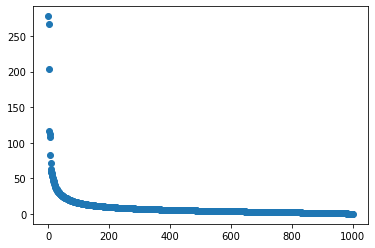

In [17]:
d=2
eps=5
Z = IsoMap(L,d,eps)

In [18]:
fig =  px.scatter(x=Z[:, 0], y=Z[:, 1], color=color)
fig.show()